In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import glob
import pandas as pd

In [2]:
# Apply the default theme
# sns.set_theme()
sns.set(style="whitegrid")

# # Load an example dataset
# tips = sns.load_dataset("tips")

# # Create a visualization
# sns.relplot(
#    data=tips,
#    x="total_bill", y="tip", col="time",
#    hue="smoker", style="smoker", size="size",
# )

In [3]:
# read in data
def make_plots_for_single_method_init_problem_combo(problem, method_init, palette_based_on_data = False):
#     filelist = glob.glob(f"output/boundary_fitness_distribution_experiment_v2/{problem}/{method_init}/run*/boundaryStats.txt")
    filelist = glob.glob(f"output/boundary_fitness_distribution_experiment_v2/{problem}/{method_init}/run_1/boundaryStats.txt")
    data = []

    # generate data
    (data_pop, data_select) = parseDataFiles(filelist)
    print("Dimensions of data (#gens\t#datapoints):")
    print(len(data_pop), len(data_pop[0]))
    print(len(data_select), len(data_select[0]))
    
    # Initialize df with first gen, create color palette based on it
    df = pd.DataFrame(data_pop[0], columns=['Boundaries', 'Fitness'])
    
    if(palette_based_on_data):
        # Create a custom color palette for each index. Assuming initial data has at least 1 datapoint for each #bins, this can be seen as the base palette. TODO MIGHT BREAK ON NORMALIZED INIT!!
        n_unique_indices = df['Boundaries'].nunique()
        color_palette = sns.color_palette("hsv", n_colors=n_unique_indices)
    else:
        # bins range from 1-8, so create color_palette accordingly
        color_palette = sns.color_palette("hsv", n_colors=8)
    
#     # Make plot of just the first generation
#     sns.set(style="whitegrid")
#     sns.kdeplot(data=df, x='Fitness', hue='Boundaries', palette=color_palette, legend=True)
    
    # Find min, max and range of fitness in data
    (x_min_p, x_max_p, x_range_p) = find_min_max_range(data_pop)
    (x_min_s, x_max_s, x_range_s) = find_min_max_range(data_select)
    
#     # Make the plots for both populations and selections
#     make_plots(f"{problem}/{method_init}", False, data_select, "sel", color_palette)
#     make_plots(f"{problem}/{method_init}", False, data_pop, "pop", color_palette)
    
    # V2: Make plots for populations and selections at the same time (so they can use corresponding x-axis limits)
    make_comparison_plots(f"{problem}/{method_init}", data_pop, data_select, color_palette)
    
    

In [4]:
def parseDataFiles(filelist):
    data_pop = []
    data_select = []
    gen = -1
    whichpop = ""
    for fn in filelist:
        with open(fn) as file:
            for line in file.readlines()[1:]:
                splitline = line.split(" ")
                if(splitline[0] == "GEN"):
                    gen = int(splitline[1])
                    whichpop = splitline[3].strip()
    #                 print(gen, whichpop)
                else:
                    bc = int(splitline[0]) # boundarycount
                    f = float(splitline[2].strip()) # fitness
                    if(whichpop == "SELECTIONS"):
                        if(len(data_select) <= gen):
                            data_select.append([[bc, f]])
                        else:
                            data_select[gen].append([bc, f])
                    elif(whichpop == "POPULATION"):
                        if(len(data_pop) <= gen):
                            data_pop.append([[bc, f]])
                        else:
                            data_pop[gen].append([bc, f])
    return (data_pop, data_select)
        

In [5]:
def find_min_max_range(data):
    # find min and max values of fitness in the data to set x-limits, so that it stays constant througout animation
    x_min = min([min([x[1] for x in data_gen]) for data_gen in data])
    x_max = max([max([x[1] for x in data_gen]) for data_gen in data])
    x_range = x_max - x_min
    return (x_min, x_max, x_range)

In [6]:
def make_plots(plot_file_name, limit_x_axis, data, select_or_pop, color_palette):
    # Make sure the necessary directories exist
    plots_dir = f"animations/{plot_file_name}"
    if not os.path.isdir(plots_dir):
        os.makedirs(plots_dir)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    
    # Create a custom line style for the highlighted line
    highlighted_line_style = '--'
    highlighted_line_width = 2
    optimal_line_index = 6 if plot_file_name.startswith("network7") else 4

    def init():
        # Create an empty DataFrame
        empty_df = pd.DataFrame(columns=['Boundaries', 'Fitness'])

        # Initialize the empty plot
        plot = sns.kdeplot(data=empty_df, x='Fitness', hue='Boundaries', palette=color_palette, common_norm=False, legend=True, ax=ax)

        # Add labels and title
        ax.set_xlabel("Fitness")
        ax.set_ylabel("Density")
        ax.set_title(f"[{plot_file_name}] Density Plot of fitness values ({select_or_pop}) : Gen 0")
        return ax,

    # Create a function to update the plot for each generation
    def update(frame):
        ax.clear()
        generation_data = data[frame]
        df = pd.DataFrame(generation_data, columns=['Boundaries', 'Fitness'])
        # Create a custom color palette for each index
        unique_indices = np.sort(df['Boundaries'].unique())
        new_color_palette = [color_palette[i-1] for i in unique_indices]
        
#         plot = sns.kdeplot(data=df, x='Fitness', hue='Boundaries', palette=new_color_palette, common_norm=False, legend=True, ax=ax)

        # Lists to track lines and labels for the legend
        lines = []
        labels = []
        
        # Plot the kernel density for each unique index with the corresponding color and line style
        for index in unique_indices:
            color = color_palette[index-1]
            linestyle = highlighted_line_style if index == optimal_line_index else '-'
            linewidth = highlighted_line_width if index == optimal_line_index else 1
            sns.kdeplot(data=df[df['Boundaries'] == index]['Fitness'], ax=ax, color=color, linestyle=linestyle, linewidth=linewidth)
            line, = ax.plot([], color=color, linestyle=linestyle, linewidth=linewidth)
            lines.append(line)
            labels.append(f'{index}')
            
#         # Highlight the line representing solutions with the ideal number of boundaries (although not necessarily the correct boundaries)
#         for index in df['Boundaries'].unique():
#             if (plot_file_name.startswith("network7") and index == 6) or (plot_file_name.startswith("randomnetwork_ew_1nodes") and index == 4):
#                 sns.kdeplot(data=df[df['Boundaries'] == index], x='Fitness', hue='Boundaries', common_norm=False, legend=True, ax=ax, palette=[color_palette[index-1]], label=f"{index}", linestyle='--', linewidth=4)
#             else:
#                 sns.kdeplot(data=df[df['Boundaries'] == index], x='Fitness', hue='Boundaries', common_norm=False, legend=True, ax=ax, palette=[color_palette[index-1]], label=f"{index}")
        
        ax.set_title(f"[{plot_file_name}] Density Plot of fitness values ({select_or_pop}) : Gen {frame}")
#         sorted_lines, sorted_labels = zip(*sorted(zip(lines, labels), key=lambda x: int(x[1])))
#         ax.legend(sorted_lines, sorted_labels, title="Boundaries")
        ax.legend(lines, labels, title="Boundaries")
        if(limit_x_axis):
            ax.set_xlim(x_min - x_range*0.05, x_max + x_range*0.05)
#         fig.savefig(frame_filename, dpi=300, bbox_inches='tight')
        return ax,

    # Create an animation
    num_generations = len(data) 
    init()

    # Save each frame as an image and collect frame filenames
    for frame in range(num_generations):
        update(frame)
        frame_filename = f"{plots_dir}/{select_or_pop}_gen_{frame:04d}.png"  # Frame filename with leading zeros
        plt.savefig(frame_filename, dpi=300, bbox_inches='tight')

    # ani.save('animations/Method_1_init_1_selection2.gif', writer='imagemagick', fps=2)


In [6]:
# V2! New version: generate plots of population and selection at the same time if possible, so they are limited to the same data range.
# If not possible, idea: first generate population plot, keep track of ranges. Then, set those ranges for selection plots as well.
# (since selections come from population, they should at least fall into those boundaries. Might be difficult to read though,
# depending of the spread of solutions in population vs selection).
# Also uses the v2 data (where Method 2 init 2 combination is fixed, as well as saving population data before iamalgam starts
#  (so the initial randomized population is saved as well))
def make_comparison_plots(plot_file_name, data_pop, data_select, color_palette):
    # Make sure the necessary directories exist
    plots_dir = f"animations/v2/run_1_only/{plot_file_name}"
    if not os.path.isdir(plots_dir):
        os.makedirs(plots_dir)

    # Create a figure and axes
    fig, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'hspace': 0.4})
    sns.set(style="whitegrid")

    # Create a custom line style for the highlighted line
    highlighted_line_style = '--'
    highlighted_line_width = 2
    optimal_line_index = 6 if plot_file_name.startswith("network7") else 4

    # Get the unique boundaries in the population data
    unique_boundaries_pop = np.sort(pd.DataFrame(data_pop[0], columns=['Boundaries', 'Fitness'])['Boundaries'].unique())

    # Create a function to initialize the plots with the first generation
    def init():
        # Initialize the empty plots
        for ax in axs:
            plot = sns.kdeplot(data=pd.DataFrame(columns=['Boundaries', 'Fitness']), x='Fitness', hue='Boundaries',
                               palette=color_palette, common_norm=False, legend=True, ax=ax)

            # Add labels and title
            ax.set_ylabel("Density")

        axs[-1].set_xlabel("Fitness")
        axs[0].set_title(f"[{plot_file_name}] Distribution Plot of fitness values (Population) : Gen 0")
        axs[1].set_title(f"[{plot_file_name}] Distribution Plot of fitness values (Selection) : Gen 0")

        return axs

    # Create a function to update the plots for each generation
    def update(frame):
        for ax in axs:
            ax.clear()

        # Plot the population data
        generation_data_pop = data_pop[frame]
        # Get the unique boundaries in the population data
        unique_boundaries_pop = np.sort(pd.DataFrame(generation_data_pop, columns=['Boundaries', 'Fitness'])['Boundaries'].unique())
        
        for boundary in unique_boundaries_pop:
            color = color_palette[boundary - 1]
            linestyle = highlighted_line_style if boundary == optimal_line_index else '-'
            linewidth = highlighted_line_width if boundary == optimal_line_index else 1
            
            filtered_data_pop = [item[1] for item in generation_data_pop if item[0] == boundary]
            weights_pop = np.ones_like(filtered_data_pop) / float(len(generation_data_pop))  # Normalize the weights
#             sns.kdeplot(data=filtered_data_pop, ax=axs[0], color=color, linestyle=linestyle, linewidth=linewidth, label=f'{boundary} ({len(filtered_data_pop)})', weights=weights_pop)
            sns.histplot(data=filtered_data_pop, ax=axs[0], color=color, stat="count", kde=True,
                     line_kws={"linestyle": linestyle, "linewidth": linewidth, "label": f'{boundary} ({len(filtered_data_pop)})'}) #, weights=weights_pop)
#             sns.kdeplot(data=pd.DataFrame(generation_data_pop, columns=['Boundaries', 'Fitness'])
#                         [generation_data_pop[:, 0] == boundary][:, 1],
#                         ax=axs[0], color=color, linestyle=linestyle, linewidth=linewidth)

        # Plot the selection data
        generation_data_select = data_select[frame]
        # Get the unique boundaries in the selection data
        unique_boundaries_select = np.sort(pd.DataFrame(generation_data_select, columns=['Boundaries', 'Fitness'])['Boundaries'].unique())
        for boundary in unique_boundaries_select:
            color = color_palette[boundary - 1]
            linestyle = highlighted_line_style if boundary == optimal_line_index else '-'
            linewidth = highlighted_line_width if boundary == optimal_line_index else 1
            
            filtered_data_select = [item[1] for item in generation_data_select if item[0] == boundary]
            weights_select = np.ones_like(filtered_data_select) / float(len(generation_data_select))  # Normalize the weights
#             sns.kdeplot(data=filtered_data_select, ax=axs[1], color=color, linestyle=linestyle, linewidth=linewidth, label=f'{boundary} ({len(filtered_data_select)})', weights=weights_select)
#             sns.kdeplot(data=pd.DataFrame(generation_data_select, columns=['Boundaries', 'Fitness'])
#                         [generation_data_select[:, 0] == boundary][:, 1],
#                         ax=axs[1], color=color, linestyle=linestyle, linewidth=linewidth)
            sns.histplot(data=filtered_data_select, ax=axs[1], color=color, stat="count", kde=True,
                     line_kws={"linestyle": linestyle, "linewidth": linewidth, "label": f'{boundary} ({len(filtered_data_select)})'}) #, weights=weights_select)

        axs[0].set_title(f"[{plot_file_name}] Distribution Plot of fitness values (Population) : Gen {frame}")
        axs[1].set_title(f"[{plot_file_name}] Distribution Plot of fitness values (Selection) : Gen {frame}")
        axs[0].legend(title="Boundaries")
        axs[1].legend(title="Boundaries")
        

        # Calculate x-axis limits based on the population data
        x_min_pop = min([min([item[1] for item in generation_data_pop if item[0] == b]) for b in unique_boundaries_pop])
        x_max_pop = max([max([item[1] for item in generation_data_pop if item[0] == b]) for b in unique_boundaries_pop])
#         x_min_pop = min([min(generation_data_pop[generation_data_pop[:, 0] == b][:, 1]) for b in unique_boundaries_pop])
#         x_max_pop = max([max(generation_data_pop[generation_data_pop[:, 0] == b][:, 1]) for b in unique_boundaries_pop])
        x_range_pop = x_max_pop - x_min_pop

        # Set x-axis limits for both population and selection plots
        axs[0].set_xlim(x_min_pop - x_range_pop * 0.05, x_max_pop + x_range_pop * 0.05)
        axs[1].set_xlim(x_min_pop - x_range_pop * 0.05, x_max_pop + x_range_pop * 0.05)
        axs[-1].set_xlabel("Fitness")

        return axs

    num_generations = len(data_pop)
    init()

    # Save each frame as an image and collect frame filenames
    for frame in range(num_generations):
        update(frame)
        frame_filename = f"{plots_dir}/gen_{frame:04d}.png"  # Frame filename with leading zeros
        plt.savefig(frame_filename, dpi=300, bbox_inches='tight')

# Example usage:
# make_comparison_plots("example", data_pop, data_select, sns.color_palette("husl", n_colors=n_unique_boundaries))


Dimensions of data (#gens	#datapoints):
5 1000
5 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

[INFO] MAKING PLOTS FOR randomnetwork_ew_1nodes, m=1, init=1
Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

[INFO] MAKING PLOTS FOR randomnetwork_ew_1nodes, m=1, init=2
Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

[INFO] MAKING PLOTS FOR randomnetwork_ew_1nodes, m=1, init=3
Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

[INFO] MAKING PLOTS FOR randomnetwork_ew_1nodes, m=2, init=1
Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


[INFO] MAKING PLOTS FOR randomnetwork_ew_1nodes, m=2, init=2
Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

[INFO] MAKING PLOTS FOR randomnetwork_ew_1nodes, m=2, init=3
Dimensions of data (#gens	#datapoints):
100 1000
100 350


C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ruben\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

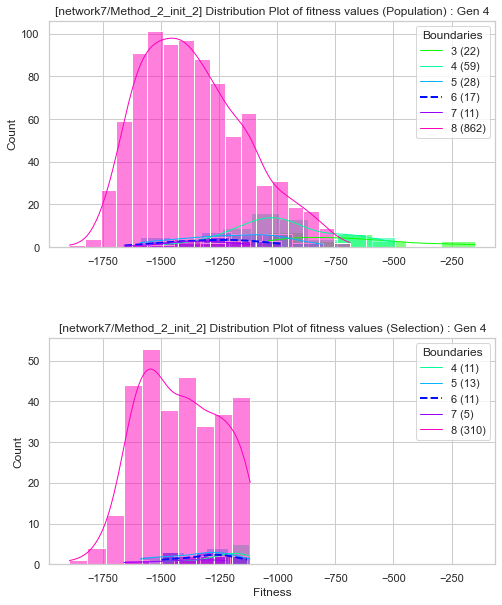

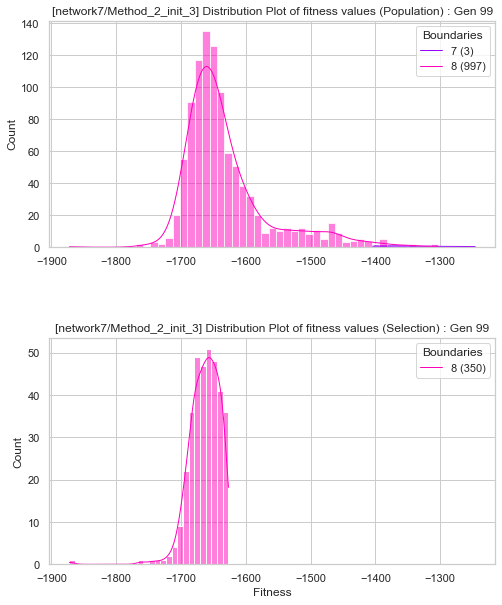

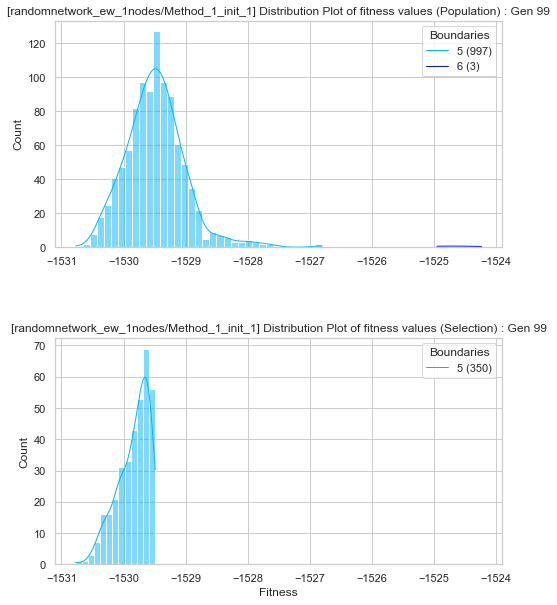

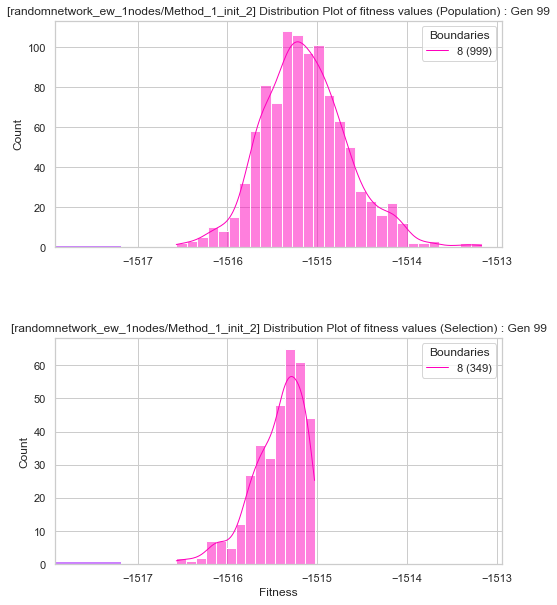

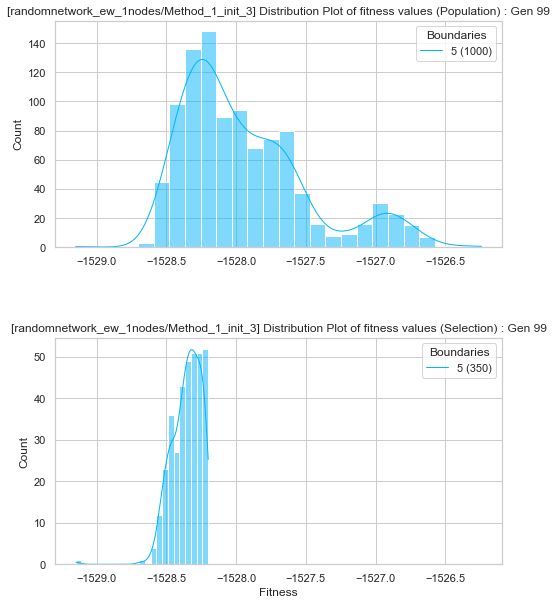

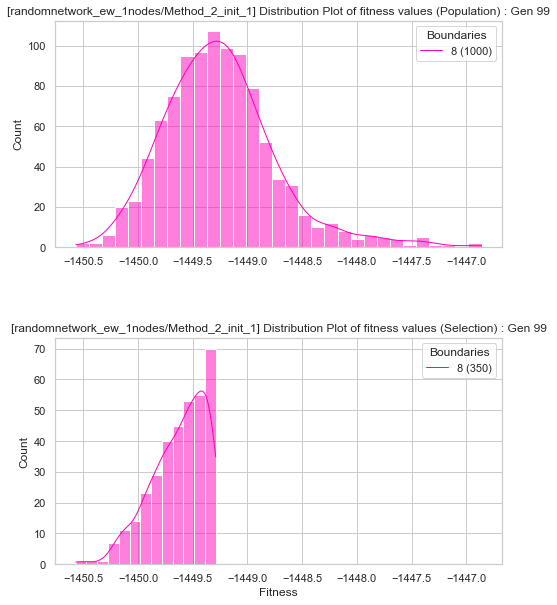

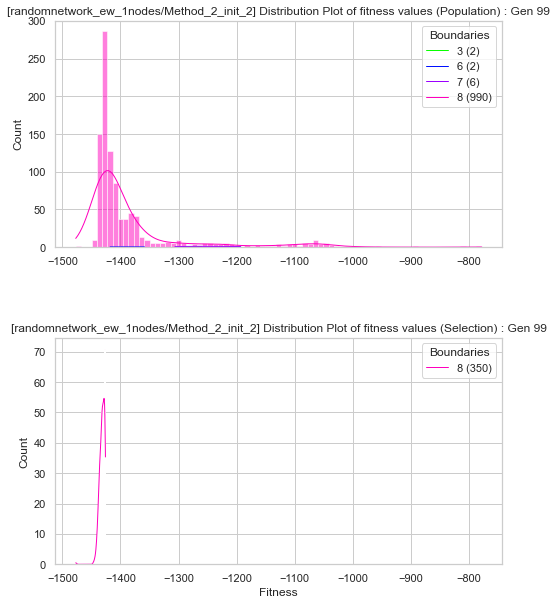

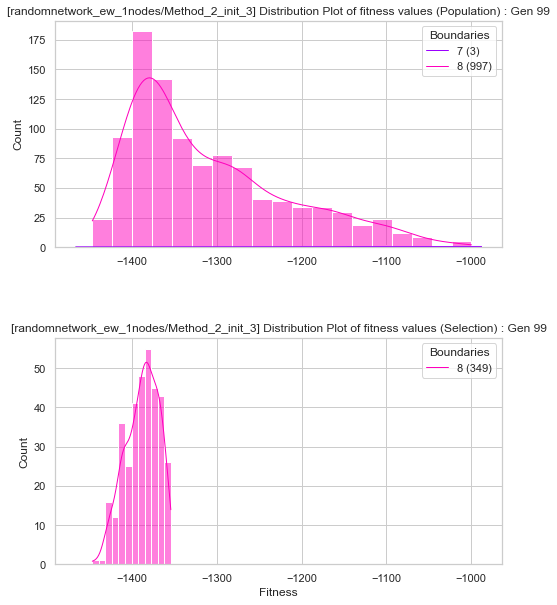

In [7]:
# Make the plots for all combinations of problems / methods
make_plots_for_single_method_init_problem_combo("network7", "Method_2_init_2")
make_plots_for_single_method_init_problem_combo("network7", "Method_2_init_3")
for prob in ["randomnetwork_ew_1nodes"]:
    for m in [1, 2]:
        for init in [1, 2, 3]:
            if True: # not ((m == 2 and init == 2)): # or (prob == "network7" and (m == 1 or init == 1))):
                print(f"[INFO] MAKING PLOTS FOR {prob}, m={m}, init={init}")
                make_plots_for_single_method_init_problem_combo(prob, f"Method_{m}_init_{init}")


### The generated pngs can be turned into a video using the commands:
```bash
ffmpeg -framerate 5 -i sel_gen_%04d.png -vf "scale=width=1920:height=1080" -c:v libx264 -crf 18 -pix_fmt yuv420p anim_sel_output.mp4
```

```bash
ffmpeg -framerate 5 -i pop_gen_%04d.png -vf "scale=width=1920:height=1080" -c:v libx264 -crf 18 -pix_fmt yuv420p anim_pop_output.mp4
```

Or both at once (and 30 fps):

```bash
ffmpeg -framerate 30 -i sel_gen_%04d.png -vf "scale=width=1920:height=1080" -c:v libx264 -crf 18 -pix_fmt yuv420p anim_sel_output.mp4;
ffmpeg -framerate 30 -i pop_gen_%04d.png -vf "scale=width=1920:height=1080" -c:v libx264 -crf 18 -pix_fmt yuv420p anim_pop_output.mp4
```

Assuming you are running this in the directory containing the images.

To automatically do this for all images in subdirectories, the following script can be used:
```bash
#!/bin/bash

# Set the root directory where the subfolders are located
root_dir="."

# Define the ffmpeg command for converting images to a video (-y to force overwrite)
ffmpeg_command="ffmpeg -y -framerate 30 -i sel_gen_%04d.png -vf "scale=width=1920:height=1080" -c:v libx264 -crf 18 -pix_fmt yuv420p anim_sel_output.mp4; ffmpeg -y -framerate 30 -i pop_gen_%04d.png -vf "scale=width=1920:height=1080" -c:v libx264 -crf 18 -pix_fmt yuv420p anim_pop_output.mp4"

# Find all the most nested directories containing images
image_dirs=$(find "$root_dir" -mindepth 2 -type d -name 'Method_*_init_*' -o -name 'randomnetwork_ew_1nodes')

# Iterate through the found directories
for dir in $image_dirs; do
    echo "Entering directory: $dir"
    # Change to the directory
    cd "$dir" || exit

    # # Run the ffmpeg command to convert images to video
    eval "$ffmpeg_command"

    # Move back to the parent directory
    cd - || exit
    echo "Returned to the parent directory"
done
```

In [18]:
# # Initialize df with first gen, create color palette based on it
# df = pd.DataFrame(data_pop[0], columns=['Boundaries', 'Fitness'])

# # Create a custom color palette for each index. Assuming initial data has at least 1 datapoint for each #bins, this can be seen as the base palette. TODO MIGHT BREAK ON NORMALIZED INIT!!
# n_unique_indices = df['Boundaries'].nunique()
# color_palette = sns.color_palette("hsv", n_colors=n_unique_indices)

# sns.set(style="whitegrid")
# sns.kdeplot(data=df, x='Fitness', hue='Boundaries', palette=color_palette, legend=True)

In [8]:
# print(df['Boundaries'].unique())
# print(len(color_palette), color_palette)

[8 2 6 5 3 4 7 1]
8 [(1.0, 0.6485300602947661, 0.0), (0.7029398794104678, 1.0, 0.0), (0.03124934374934376, 1.0, 1.3125013124790507e-06), (0.0, 1.0, 0.617278533938476), (0.0, 0.7110320290467349, 1.0), (0.0, 0.062501968751969, 1.0), (0.6091898794104678, 0.0, 1.0), (1.0, 0.0, 0.742280060294766)]


In [9]:
# df['Boundaries'].value_counts()

4    3358
3    3149
5    1880
2     737
6     635
7     182
8      51
1       8
Name: Boundaries, dtype: int64

In [48]:
# data = data_select

In [28]:
# FFwriter = ani.FFMpegFileWriter(fps=2)
# ani.save('animations/test_animation2.mp4', writer=FFwriter)
# # print(ani.__dir__())

      total_bill    n
size                 
1       7.242500    4
2      16.448013  156
3      23.277632   38
4      28.613514   37
5      30.068000    5
6      34.830000    4


<AxesSubplot:xlabel='total_bill', ylabel='Density'>

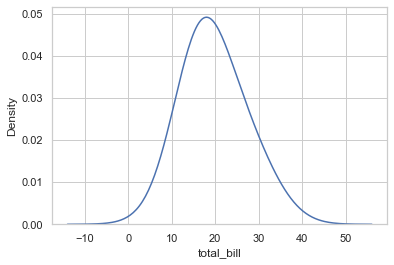

In [120]:
tips = sns.load_dataset("tips")
tips_agg = (tips
    .groupby("size")
    .agg(total_bill=("total_bill", "mean"), n=("total_bill", "count"))
)
print(tips_agg)
weights = [4, 156, 38, 37, 5, 4] #[0.01 for _ in range(6)]
sns.kdeplot(data=tips_agg, x='total_bill', weights=weights)

In [ ]:
sns.histplot(data=[1, 1, 1, 1])